# Best DCA setup
Questions:
 - should DCA frequency be weekly, bi-weekly or monthly? 
 - should it be done on a specific day of the week or day of the month?

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from lib.data_load.csvs import get_btcusdt_data
from lib.strategies import DCA, DummyFNGDCA, DummyRollingFNGDCA, DummyCategoricFNGDCA, RelativeMean, RelativeCategoricalMean, MeanFNGDCA

# Set experiment parameters

START = "2018-01-01"
END = "2022-05-01"
WEEKLY_INVESTMENT = 100
PRICE_TODAY = 38_100

# Collect BTC data

df = get_btcusdt_data(START, END)

df.head(10)

,unix,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount,dayofweek,dayofmonth
date,,,,,,,,,,,
2022-05-01,1.651363e+12,BTC/USDT,37630.80,38675.00,37386.38,38468.35,38812.24104,1.478259e+09,1021157.0,Sunday,1
2022-04-30,1.651277e+12,BTC/USDT,38596.11,38795.38,37578.20,37630.80,35321.18989,1.354901e+09,1017369.0,Saturday,30
2022-04-29,1.651190e+12,BTC/USDT,39742.06,39925.25,38175.00,38596.11,51453.65715,2.006136e+09,1101140.0,Friday,29
2022-04-28,1.651104e+12,BTC/USDT,39235.72,40372.63,38881.43,39742.07,56086.67150,2.223808e+09,1135242.0,Thurstday,28
2022-04-27,1.651018e+12,BTC/USDT,38112.64,39474.72,37881.31,39235.72,57083.12272,2.218524e+09,1232083.0,Wednesday,27
2022-04-26,1.650931e+12,BTC/USDT,40426.08,40797.31,37702.26,38112.65,66650.25800,2.615207e+09,1381618.0,Tuesday,26
2022-04-25,1.650845e+12,BTC/USDT,39450.12,40616.00,38200.00,40426.08,63037.12784,2.470071e+09,1280351.0,Monday,25
2022-04-24,1.650758e+12,BTC/USDT,39441.61,39940.00,38929.62,39450.13,26703.61186,1.056336e+09,868183.0,Sunday,24
2022-04-23,1.650672e+12,BTC/USDT,39709.19,39980.00,39285.00,39441.60,20291.42375,8.046770e+08,724132.0,Saturday,23


Add week of month and biweekly column to the dataframe.

In [47]:
df = df.assign(biweekly=df.dayofmonth%15)

In [48]:
def get_test_strategy(groupby_column="dayofweek"):
    
    def test_strategy(df, column_name, price_today):
        
        results = []
        
        for day, df_dow in df.groupby(groupby_column):
            
            df_dow = df_dow.assign(cripto_obtained=df_dow[column_name] / df_dow.close)
            
            results.append({
                "strategy": column_name,
                "day": day,
                "fiat_invested": df_dow[column_name].sum(),
                "btc_obtained": df_dow.cripto_obtained.sum(),
                "fiat_value": df_dow.cripto_obtained.sum() * price_today,        
            
        })
        
        df_results = pd.DataFrame(results)
        
        df_results = df_results.assign(gain_perc=df_results.fiat_value / df_results.fiat_invested)
        df_results = df_results.assign(avg_price=df_results.fiat_invested / df_results.btc_obtained)
        
        return df_results
    
    return test_strategy

In [49]:
df = df.assign(dca_weekly=DCA(WEEKLY_INVESTMENT).apply(df))
df = df.assign(dca_biweekly=DCA(WEEKLY_INVESTMENT * 2).apply(df))
df = df.assign(dca_monthly=DCA(WEEKLY_INVESTMENT * 4).apply(df))

df_results = pd.concat([
    get_test_strategy("dayofmonth")(df, "dca_monthly", PRICE_TODAY),
    get_test_strategy("biweekly")(df, "dca_biweekly", PRICE_TODAY),
    get_test_strategy("dayofweek")(df, "dca_weekly", PRICE_TODAY)
    ]
)

Text(0.5, 0.98, 'AVG Price by DCA Frequency')

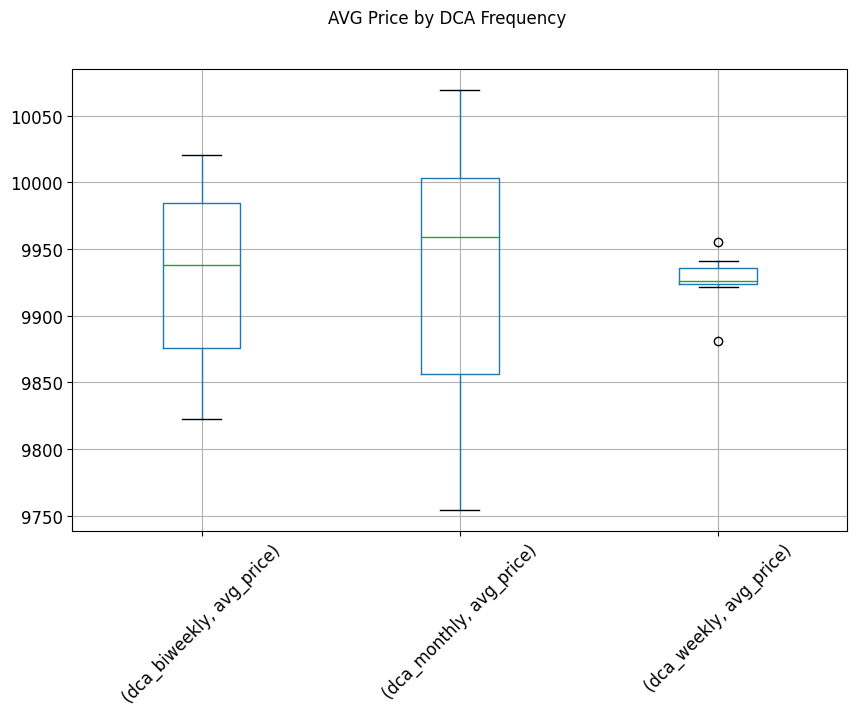

In [50]:
df_results[["strategy", "avg_price"]].groupby("strategy").boxplot(subplots=False, rot=45, fontsize=12, figsize=(10, 6))
plt.suptitle("AVG Price by DCA Frequency")

Weekly DCA is less subject to volatility and presents a slighlty lower median price overall.

## Best day(s) of the month for DCA?

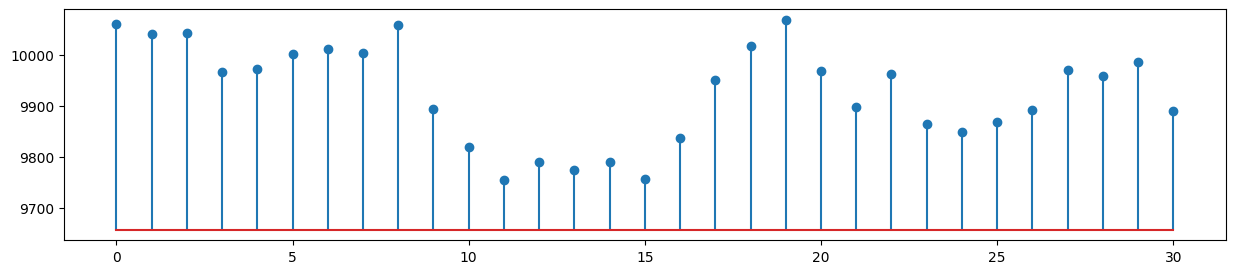

In [51]:
x = df_results[df_results.strategy=="dca_monthly"].avg_price.values

fig, ax = plt.subplots(figsize=(15, 3))
ax.stem(x, bottom=min(x)*0.99)
plt.show()

Seems like different weeks in the month have different performances!

<AxesSubplot:>

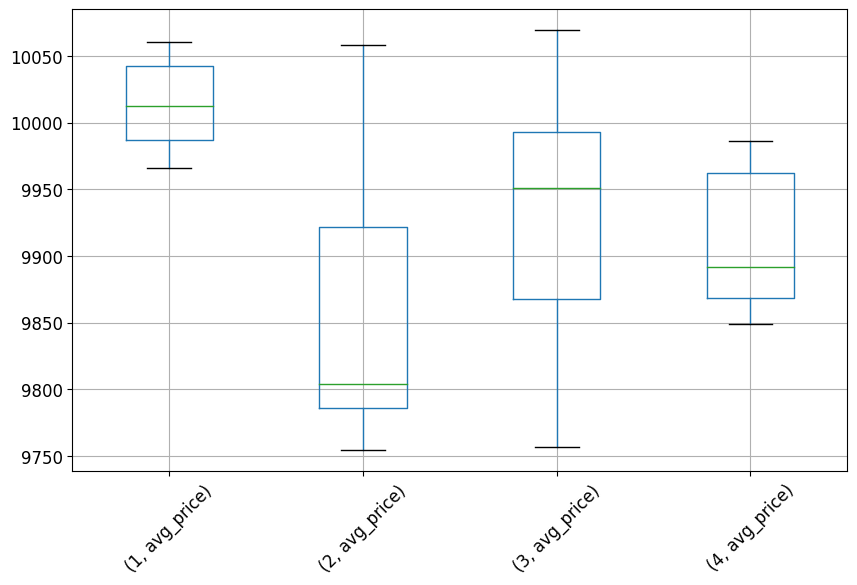

In [52]:
def assign_monthly_period(dayofmonth):
    """Split the month in 4 periods
    """
    if 0 < dayofmonth <= 7:
        return "1"
    elif 8 <= dayofmonth <= 15:
        return "2"
    elif 16 <= dayofmonth <= 22:
        return "3"
    else:
        return "4"

df_month = get_test_strategy("dayofmonth")(df, "dca_monthly", PRICE_TODAY)
df_month = df_month.assign(month_period=df_month.day.apply(assign_monthly_period))

df_month[["month_period", "avg_price"]].groupby("month_period").boxplot(subplots=False, rot=45, fontsize=12, figsize=(10, 6))

These boxplots suggest that the average price of BTC tends to be lower during the second and the last week of the month.

## Best day(s) of the week for DCA?

/var/folders/s3/tsnqhqws2cn94l00mhwy94d80000gn/T/ipykernel_1237/491136555.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(ticks))


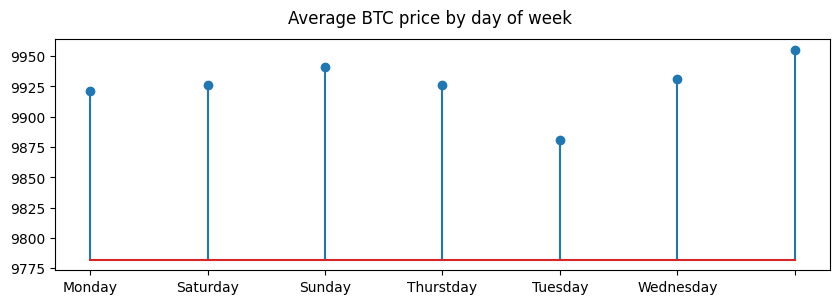

In [53]:
x = df_results[df_results.strategy=="dca_weekly"].avg_price.values
ticks = df_results[df_results.strategy=="dca_weekly"].day.values

fig, ax = plt.subplots(figsize=(10, 3))
ax.stem(x, bottom=min(x)*0.99)
ax.set_xticklabels(list(ticks))
fig.suptitle("Average BTC price by day of week")
plt.show()

Difference of performance between the best and the worst weekday for DCA:

In [54]:
prices = df_results[df_results.strategy=="dca_weekly"].avg_price.values
fiat_amounts = df_results[df_results.strategy=="dca_weekly"].fiat_value.values

print("Best vs. worst DCA weekly day:")
print(f"Best avg price:\t\t\t{min(prices)}")
print(f"Worst avg price:\t\t{max(prices)}")
print(f"Performance difference in %:\t{abs(100 * (1 - max(prices)/min(prices)).round(5))} %")
print(f"Fiat difference:\t\t{max(fiat_amounts) - min(fiat_amounts)}")

Best vs. worst DCA weekly day:
Best avg price:			9880.815240991877
Worst avg price:		9955.271334466179
Performance difference in %:	0.754 %
Fiat difference:		651.7601165681408


Conclusions: having a favorite day of the week for DCA won't make a big difference on the long term.